In [2]:
Sys.setenv(SPARK_HOME='/usr/lib/spark')
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

In [3]:
library(SparkR)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union



In [4]:
appName <- 'co_clustering'
masterURL <- 'spark://emma0.phenovari-utwente.surf-hosted.nl:7077'

sc <- sparkR.session(master=masterURL, appName=appName)


Spark package found in SPARK_HOME: /usr/lib/spark


Launching java with spark-submit command /usr/lib/spark/bin/spark-submit   sparkr-shell /tmp/Rtmpqfodr4/backend_port28652040a3ff 


## Bregman block average co-clustering algorithm.

The implementation of Bregman block average co-clustering algorithm (Banerjee et al., 2007) is inpired in the [single node impementation](https://github.com/fnyanez/bbac), [Copyright (c) 2016 Felipe Yanez](https://github.com/fnyanez/bbac/blob/master/LICENSE.md).

### Support functions

```
coCavg <- function(dist, row_col, R, Z, C, W, epsilon) {
  CoCavg <- calculate_average(R, Z, C, W, epsilon)
  if (row_col=="row") {
    return(list(Zrowc = array(dist, dim(Z)), Zrowv = CoCavg %*% t(C)))
  } else if (row_col=="col") {
    return(list(Zcolc = array(dist, dim(Z)), Zcolv = R %*% CoCavg))
  }
}
```

In [ ]:
coCavg <- function(dist, row_col, R, matrixDF, C, W, epsilon) {
    CoCavg <- calculate_average(R, matrixDF, C, W, epsilon)
    if (row_col=="row") {
        return(list(Zrowc = array(dist, dim(matrixDF)), Zrowv = CoCavg %*% t(C)))
    } else if (row_col=="col") {
        return(list(Zcolc = array(dist, dim(matrixDF)), Zcolv = R %*% CoCavg))
    }
}

```
calculate_average <- function(Left, Z, Right, W, epsilon) {
  if (is.null(W)) {W <- array(1, dim(Z))} else {Z <- W * Z}
  numerator <- t(Left) %*% Z %*% Right + mean(Z) * epsilon
  denominator <- t(Left) %*% W %*% Right + epsilon
  return(numerator/denominator)
}
```

In [ ]:
calculate_average <- function(Left, matrixDF, Right, W, epsilon) {
    if (is.null(W)) {
        #W <- array(1, dim(matrixDF))
        W <- spark.createDataFrame(sc.emptyRDD[Row], schema)
    } else {
        matrixDF <- W * matrixDF
    }
    numerator <- t(Left) %*% matrixDF %*% Right + mean(matrixDF) * epsilon
    denominator <- t(Left) %*% W %*% Right + epsilon
    return(numerator/denominator)
}

```
similarity_measure <- function(dist, Z, X, Y, W, epsilon) {
  if (is.null(W)) W <- array(1, dim(Z))
  if (dist==0) {
    euc <- function(i) rowSums(W * (Z - X - rep(Y[i,], each = dim(Z)[1]))^2)
    return(sapply(1:dim(Y)[1], euc))
  } else if (dist==1) {
    return((W * X) %*% t(Y + epsilon) - (W * Z) %*% log(t(Y + epsilon)))
  }
}
```

In [ ]:
similarity_measure <- function(dist, matrixDF, X, Y, W, epsilon) {
    if (is.null(W))
        W <- array(1, dim(matrixDF))
    if (dist==0) {
        euc <- function(i) rowSums(W * (matrixDF - X - rep(Y[i,], each = dim(matrixDF)[1]))^2)
            return(sapply(1:dim(Y)[1], euc))
    } else if (dist==1) {
        return((W * X) %*% t(Y + epsilon) - (W * Z) %*% log(t(Y + epsilon)))
    }
}

```
assign_cluster <- function(dist, Z, X, Y, W, epsilon) {
  D <- similarity_measure(dist, Z, X, Y, W, epsilon)
  id <- sapply(1:dim(D)[1], function(i) sort(D[i,], index.return = TRUE)$ix[1])
  res <- sapply(1:dim(D)[1], function(i) sort(D[i,])[1]^(2-dist))
  return(list(Cluster = diag(dim(Y)[1])[id,], Error = sum(res)))
}
```

In [ ]:
assign_cluster <- function(dist, matrixDF, X, Y, W, epsilon) {
    D <- similarity_measure(dist, matrixDF, X, Y, W, epsilon)
    id <- sapply(1:dim(D)[1], function(i) sort(D[i,], index.return = TRUE)$ix[1])
    res <- sapply(1:dim(D)[1], function(i) sort(D[i,])[1]^(2-dist))
    return(list(Cluster = diag(dim(Y)[1])[id,], Error = sum(res)))
}

### BBAC
```
Z - m x n data matrix, 
W - m x n measure matrix, 
k - num row clusters,
l - num col clusters
```

In [11]:
bbac <- function(matrixDF, numRowC, numColC, W = NULL, distance = "euclidean", errobj = 1e-6, niters = 100, nruns = 5, epsilon = 1e-8) {
  
  error <- Inf
  error_now <- Inf
  dist <- pmatch(tolower(distance), c("euclidean","divergence")) - 1
  
  for (r in 1:nruns) {
    
    # Initialization of R and C
    R <- diag(numRowC)[base::sample(numRowC, dim(matrixDF)[1], replace = TRUE),]
    C <- diag(numColC)[base::sample(numColC, dim(matrixDF)[2], replace = TRUE),]
    
    for (s in 1:niters) {
      
      # Row estimation
      rs <- coCavg(dist, "row", R, matrixDF, C, W, epsilon)
      ra <- assign_cluster(dist, matrixDF, rs$Zrowc, rs$Zrowv, W, epsilon)
      R  <- ra$Cluster
      
      # Column estimation
      cs <- coCavg(dist, "col", R, matrixDF, C, W, epsilon)
      ca <- assign_cluster(dist, t(matrixDF), t(cs$Zcolc), t(cs$Zcolv), W, epsilon)
      C  <- ca$Cluster
      
      # 
      if (abs(ca$Error - error_now) < errobj) {
        status <- paste("converged in",s,"iterations")
        return(list(R = R, C = C, status = status))
      }
      
      # Update objective value
      error_now <- ca$Error
      
    }
    
    # Keep pair with min error
    if (error_now < error) {
      R_star <- R
      C_star <- C
      error <- error_now
    }
    
  }
  
  status <- paste("reached maximum of", niters, "iterations")
  return(list(R = R_star, C = C_star, status = status))
  
}

### Load Data

The data will be loaded from a matrix create in Scala and saved as Parquet file.

In [5]:
set.seed(1)
input_matrix <- matrix(rep(1:4, 25), 10, 10)

### Run 

In [14]:
# Run co-clustering algorithm
bbac_res <- bbac(matrixDF, k = 2, l = 2, distance = "e")

ERROR: Error in t(Left) %*% Z: requires numeric/complex matrix/vector arguments


In [ ]:
dim(matrixDF)

### Plot results

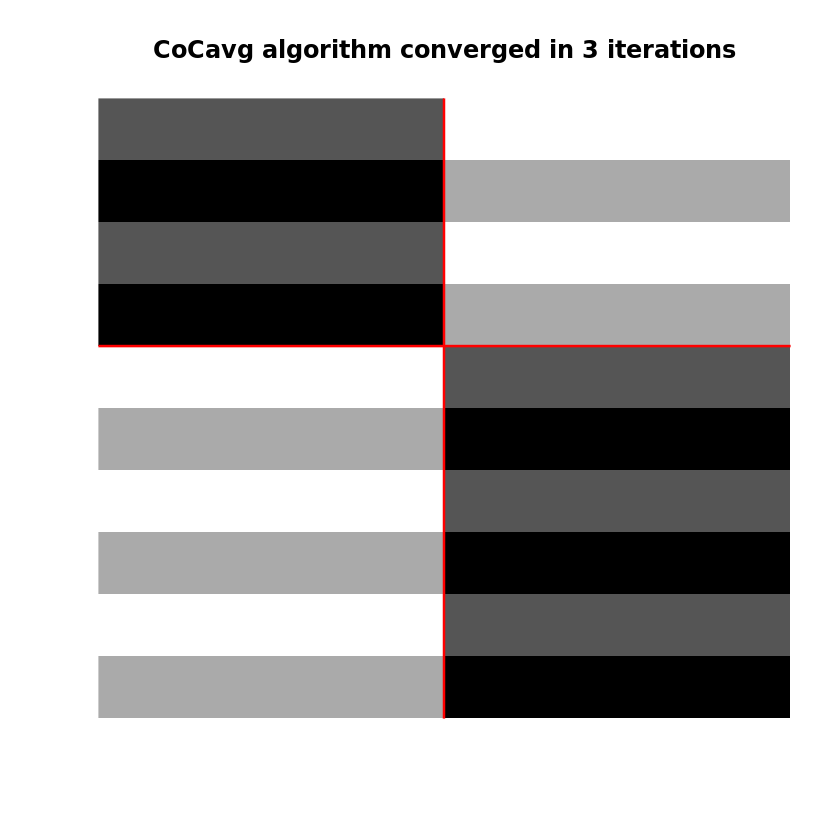

In [9]:
plot_coclusters <- function(Z, R, C) {
  # Sort matrix
  Y <- t(Z[(R * (1:nrow(R)))[R != 0], (C * (1:nrow(C)))[C != 0]])
    
  # Plot sorted matrix
  image(seq(0, 1, length.out = dim(Y)[1]), seq(0, 1, length.out = dim(Y)[2]),
        Y, col = grey((0:12)/12), axes = FALSE, xlab = "", ylab = "")
    
  # Print row clusters
  row_clust <- (head(cumsum(colSums(R)), -1) - 0.5)/(ncol(Y) - 1)
  invisible(sapply(1:length(row_clust), function(i) 
    segments(-0.5, row_clust[i], 1.5, row_clust[i], col = 2, lwd = 2)))
  
  # Print column clusters
  col_clust <- (head(cumsum(colSums(C)), -1) - 0.5)/(nrow(Y) - 1)
  invisible(sapply(1:length(col_clust), function(i) 
    segments(col_clust[i], -0.5, col_clust[i], 1.5, col = 2, lwd = 2)))
}
                   
# Show co-clusters
par(mfrow=c(1, 1))
plot_coclusters(input_matrix, bbac_res$R, bbac_res$C)
title(paste("CoCavg algorithm", bbac_res$status))